In [19]:
from glob import glob
import os

import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

positive_labels = [1] * 50
negative_labels = [0] * 50
ordered_labels = positive_labels + negative_labels

output_dir = "results/alphaflow_2"

labels = []
ligand_ids = []
confidences = []
affinities = []
cnn_scores = []

for ligand_dir in glob(os.path.join(output_dir, "*")):
    ligand_files = os.listdir(ligand_dir)
    if not ligand_files:
        print("Empty directory: {}".format(ligand_dir))
        continue
    ligand_id = os.path.basename(ligand_dir)
    ligand_id = int(ligand_id.split("_")[1])
    for ligand_file in ligand_files:
        confidence = None
        if "rank1_" in ligand_file:
            ligand_file_name = ligand_file.replace(".sdf", "")
            confidence = ligand_file_name.split("-")[-1]
            confidence = float(confidence)
            break
        
    with open(os.path.join(ligand_dir, "minimized.sdf")) as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if "<minimizedAffinity>" in line:
                affinity = float(lines[i+1])
            if "<CNNscore>" in line:
                cnn_score = float(lines[i+1])
    ligand_ids.append(ligand_id)
    labels.append(ordered_labels[ligand_id])
    confidences.append(confidence)
    affinities.append(affinity)
    cnn_scores.append(cnn_score)
    
results = pd.DataFrame({"ligand_id": ligand_ids, "label": labels, "confidence": confidences, "affinity": affinities, "cnn_score": cnn_scores})
results.to_csv(f"results/{os.path.basename(output_dir)}.csv", index=False)

Empty directory: results/alphaflow_2/ligand_69


In [20]:
def normalize(scores: list):
    max_score = max(scores)
    min_score = min(scores)
    return [(score - min_score) / (max_score - min_score) for score in scores]

normalized_confidences = normalize(confidences)
normalized_affinities = normalize(affinities)
normalized_cnn_scores = normalize(cnn_scores)
# scores = [1-conf for conf in scores]
# scores

AUC-ROC confidence:  0.5153061224489796
AUC-ROC affinity:  0.6024489795918367
AUC-ROC CNN score:  0.4040816326530612


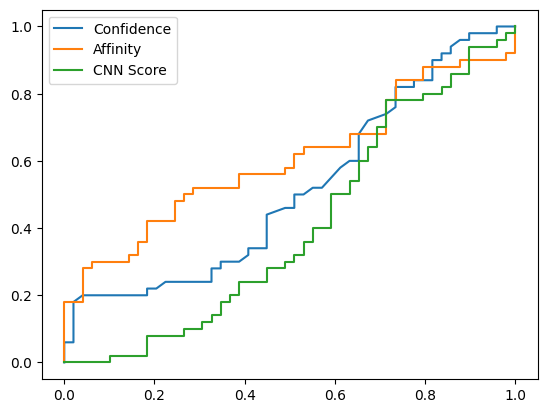

In [21]:
confidence_fpr, confidence_tpr, _ = roc_curve(labels, normalized_confidences)
affinity_fpr, affinity_tpr, _ = roc_curve(labels, normalized_affinities)
cnn_fpr, cnn_tpr, _ = roc_curve(labels, normalized_cnn_scores)

print("AUC-ROC confidence: ", roc_auc_score(labels, normalized_confidences))
print("AUC-ROC affinity: ",roc_auc_score(labels, normalized_affinities))
print("AUC-ROC CNN score: ",roc_auc_score(labels, normalized_cnn_scores))

plt.plot(confidence_fpr, confidence_tpr, label="Confidence")
plt.plot(affinity_fpr, affinity_tpr, label="Affinity")
plt.plot(cnn_fpr, cnn_tpr, label="CNN Score")
plt.legend()
plt.show()